In [1]:
#Import the libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from itertools import groupby
import os, os.path
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import davies_bouldin_score

In [2]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
filename = 'user_301_latlontime.csv'
df = pd.read_csv(filename, encoding='utf-8')
# represent points consistently as (Latitude, Longitude)
coords = df[['Latitude', 'Longitude']].to_numpy()
user_time = user_time = df['Time'].values.tolist()
# define epsilon as 0.05 kilometers, converted to radians for use by haversine
#epsilon = 10 / kms_per_radian
epsilon = 0.1

In [3]:
# To find minPoints using merge-sort algorithm
l=1
r=len(coords)
v=[]
w=[]
def divide(l, r):
    if l<r:
        m = l+(r-l)//2
        try:
            sil_score, num_clusters = cal(m, epsilon)
            if sil_score not in v and num_clusters>0:
                v.append(sil_score)
                w.append(m)
                divide(l, m)
        except ValueError:
            divide(l, m)
    else:
        return
def cal(m,epsilon):
    db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    sil_score = metrics.silhouette_score(coords, db.labels_)
    num_clusters = len(set(db.labels_)) #- (1 if -1 in db.labels_ else 0)
    return [sil_score, num_clusters]
divide(l,r)
max_i = max(v)
max_i_index = v.index(max_i)
min_point = w[max_i_index]


In [4]:
db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Silhouette coefficient: 0.759


In [5]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters-1)])
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    (freq,s) = cluster.shape
    frequency = list([freq])
    val = list(centermost_point)
    val += frequency
    return tuple(val)

centermost_points = clusters.map(get_centermost_point)

In [6]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
Latitude, Longitude, Freq = zip(*centermost_points)
# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Latitude':Latitude, 'Longitude':Longitude,'Frequency of occurence':Freq})
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['Latitude']==row['Latitude']) & (df['Longitude']==row['Longitude'])].iloc[0], axis=1)
rs_freq = rep_points.loc[:,['Frequency of occurence']]

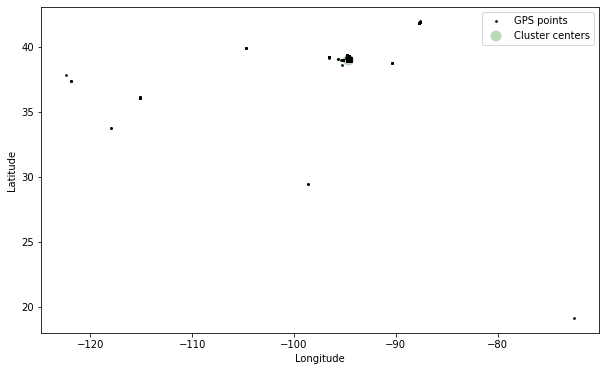

In [7]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
#rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
rep_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
#ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rep_scatter], ['GPS points', 'Cluster centers'], loc='upper right')
plt.show()

In [8]:
print(num_clusters)

2


In [9]:
print(davies_bouldin_score(coords, cluster_labels))

6.2031075271672735


### Calculation of Entropy after each recorded GPS point

In [10]:
def calculate_entropy(freq):
    Probabilities = []
    sum_of_all_freq=0
    for ele in range(0, len(freq)):
        sum_of_all_freq = sum_of_all_freq + freq[ele]
    max_size = len(freq)
    for i in range(max_size):
      Prob = freq[i]/sum_of_all_freq
      Probabilities.append(Prob)
    entropy_of_loc = -np.sum(Probabilities*np.log2(Probabilities))
    return entropy_of_loc

In [11]:
df2 = pd.read_csv('user_301_latlontime.csv', encoding='utf-8')
#df2 = df2.iloc[: , 1:]
coords = df2[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df2['Time'].values.tolist()

In [12]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

### Mapping of points in a 3D space-time grid and calculate entropy after addition of each new point

In [13]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),10)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), 10)
Z = np.linspace(0,24,24)
d=1
grids_index = np.zeros((10,10,24))
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
allover_entropy=[]

for t in range(24):
    for yax in range(10):
        for xax in range(10):
            grids_index[xax,yax,t]=d
            d=d+1
            

for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            found_grid_index.append(int(found_at))
    frequency_of_grids = [len(list(group)) for key, group in groupby(found_grid_index)]
    current_entropy = calculate_entropy(frequency_of_grids)
    allover_entropy.append(current_entropy)

### Normalizing the data points

In [14]:
scaler = MinMaxScaler()
model=scaler.fit(df2)
scaled_data=model.transform(df2)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

### Find points that can be transmitted directly

In [15]:
max_limit = (0.1/100)*len(coords)
delta_1 = 0.05
new_data = []
scaled_points = []
for temp in range(len(allover_entropy)-1):
    if allover_entropy[temp] != 0:
        percent_change = ((allover_entropy[temp+1]-allover_entropy[temp])/allover_entropy[temp])*100
        if percent_change > delta_1:
            new_data.append(df.iloc[temp].tolist())
            #scaled_points.append(scaled_data[temp].tolist())

In [16]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
new_coords = new_df[['Latitude', 'Longitude']].to_numpy()

In [17]:
print(len(new_coords))

367


### Clustering of directly transmitted data points

In [18]:
# To find minPoints using merge-sort algorithm
l=1
r=len(new_coords)
v=[]
w=[]
def divide(l, r):
    if l<r:
        m = l+(r-l)//2
        try:
            sil_score, num_clusters = cal(m, epsilon)
            if sil_score not in v and num_clusters>0:
                v.append(sil_score)
                w.append(m)
                divide(l, m)
        except ValueError:
            divide(l, m)
    else:
        return
def cal(m,epsilon):
    db = DBSCAN(eps=epsilon, min_samples=m, algorithm='ball_tree', metric='haversine').fit(np.radians(new_coords))
    sil_score = metrics.silhouette_score(new_coords, db.labels_)
    num_clusters = len(set(db.labels_)) #- (1 if -1 in db.labels_ else 0)
    return [sil_score, num_clusters]
divide(l,r)
max_i = max(v)
max_i_index = v.index(max_i)
min_point = w[max_i_index]


In [19]:
db = DBSCAN(eps=epsilon, min_samples=min_point, algorithm='ball_tree', metric='haversine').fit(np.radians(new_coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(new_coords, cluster_labels)))

Silhouette coefficient: 0.758


In [20]:
print(num_clusters)

2


In [21]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([new_coords[cluster_labels==n] for n in range(num_clusters-1)])
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    (freq,s) = cluster.shape
    frequency = list([freq])
    val = list(centermost_point)
    val += frequency
    return tuple(val)

centermost_points = clusters.map(get_centermost_point)

In [22]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
Latitude, Longitude, Freq = zip(*centermost_points)
# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Latitude':Latitude, 'Longitude':Longitude,'Frequency of occurence':Freq})
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: new_df[(new_df['Latitude']==row['Latitude']) & (new_df['Longitude']==row['Longitude'])].iloc[0], axis=1)
rs_freq = rep_points.loc[:,['Frequency of occurence']]

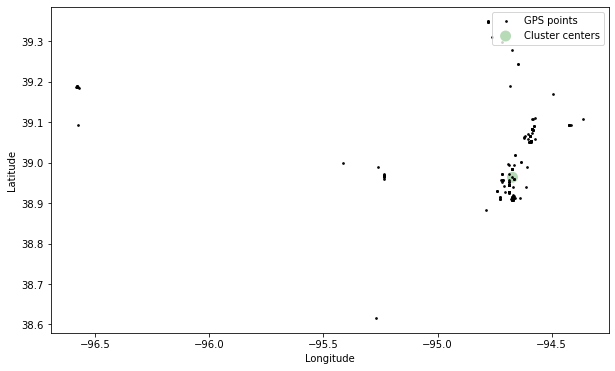

In [23]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
#rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
rep_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(new_df['Longitude'], new_df['Latitude'], c='k', alpha=0.9, s=3)
#ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rep_scatter], ['GPS points', 'Cluster centers'], loc='upper right')
plt.show()

In [24]:
print(davies_bouldin_score(new_coords, cluster_labels))

1.357114454057347
